# Fake News Prediction

## Preparation

In [ ]:
!pip install kaggle
!pip install pyspellchecker

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permission
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

In [ ]:
from zipfile import ZipFile

file_name = "fake-and-real-news-dataset.zip"

with ZipFile(file_name, "r") as files:
  files.extractall()
  print("Done")

In [18]:
#Library

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import string
import re

from collections import defaultdict
from collections import Counter

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.util import ngrams
stop = list(stopwords.words("english"))


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, log_loss,confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score
from spellchecker import SpellChecker

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\setia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [22]:
fake["type"] = 1
true["type"] = 0

In [23]:
lst = []
for text in true["text"]:
  temp = re.sub(r"^.*Reuters+\W+[-]+\W", r"", text)
  lst.append(temp)

In [24]:
true["text"] = lst

In [25]:
df = pd.concat([fake,true], axis = 0).reset_index(drop = True)

In [26]:
df.head()

,title,text,subject,date,type
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


## Exploratory Data Analysis

### Visualization of Target Label (Type)

Text(0.5, 1.0, 'Bar Chart of Type')

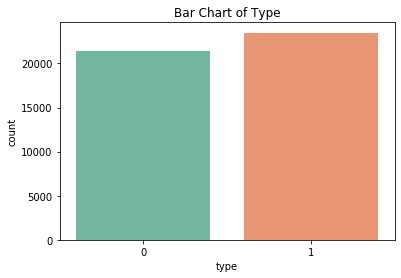

In [28]:
ax = sns.countplot(x = "type", data = df, palette = "Set2")
ax.set_title("Bar Chart of Type")

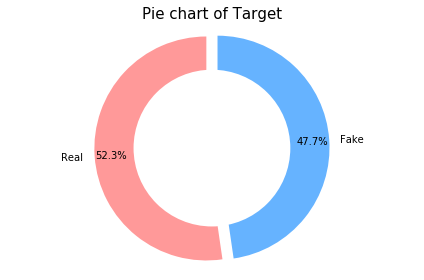

In [29]:
#Pie chart of Target
labels = ['Real', 'Fake']
values = df['type'].value_counts()
colors = ['#ff9999','#66b3ff']
explode = (0.05,0.05)

fig1, ax1 = plt.subplots()

plt.pie(values, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')
ax1.set_title("Pie chart of Target", 
              fontdict = {'fontsize' : 15,
                          'fontweight' : 10},
              loc = 'center')
plt.tight_layout()
plt.show()

### Number of character

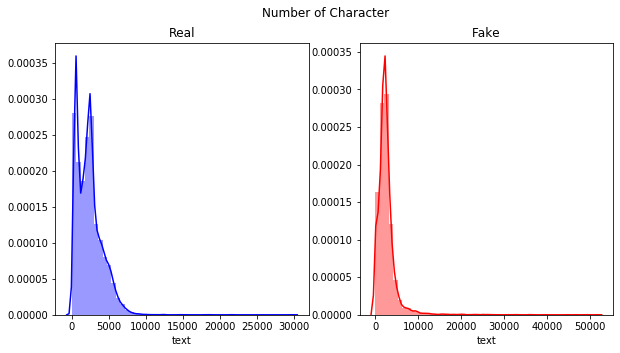

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

num_char1 = df.loc[df['type'] == 0, "text"].str.len()
sns.distplot(num_char1, ax = ax1, color = "blue")
ax1.set_title("Real")

num_char2 = df.loc[df['type'] == 1, "text"].str.len()
sns.distplot(num_char2, ax = ax2, color = "red")
ax2.set_title("Fake")

fig.suptitle("Number of Character")
plt.show()

### Number of word



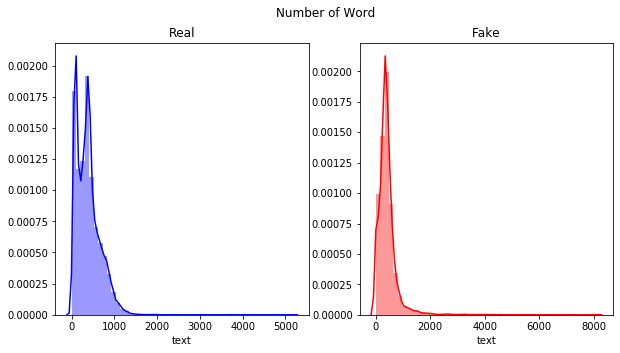

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

num_word1 = df.loc[df['type'] == 0, "text"].str.split().map(lambda x : len(x))
sns.distplot(num_word1, ax = ax1, color = "blue")
ax1.set_title("Real")

num_word2 = df.loc[df['type'] == 1, "text"].str.split().map(lambda x : len(x))
sns.distplot(num_word2, ax = ax2, color = "red")
ax2.set_title("Fake")

fig.suptitle("Number of Word")

plt.show()

### Mean of character in word



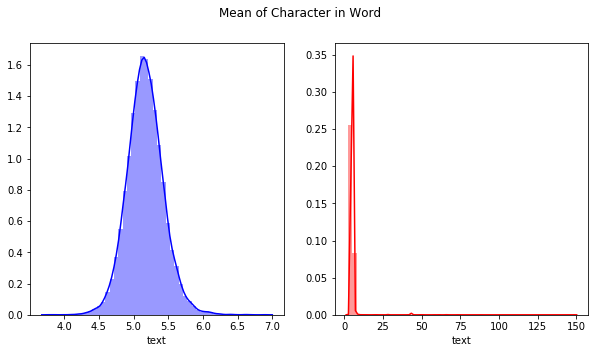

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

mean_char1 = df.loc[df["type"] == 0, "text"].str.split().map(lambda x : [len(i) for i in x])
sns.distplot(mean_char1.map(lambda x : np.mean(x)), ax = ax1, color = "blue")

mean_char2 = df.loc[df["type"] == 1, "text"].str.split().map(lambda x : [len(i) for i in x])
sns.distplot(mean_char2.map(lambda x : np.mean(x)), ax = ax2, color = "red")

fig.suptitle("Mean of Character in Word")
plt.show()

### Stopwords Analysis



In [39]:
# Make Corpus

def make_corpus(type):
  corpus = []

  for text in df.loc[df["type"] == type, "text"].str.split():
    for word in text:
      corpus.append(word.lower())
  
  return(corpus)

#### Corpus - Real

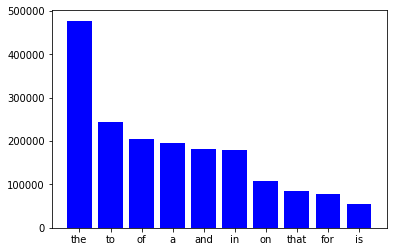

In [40]:
corpus_real = make_corpus(0)
dic_real = defaultdict(int)

for word in corpus_real:
  if word in stop:
    dic_real[word] = dic_real[word] + 1

top = sorted(dic_real.items(), key = lambda x : x[1], reverse = True)[:10]

x,y = zip(*top)
plt.bar(x,y, color = "blue");

#### Corpus - Fake

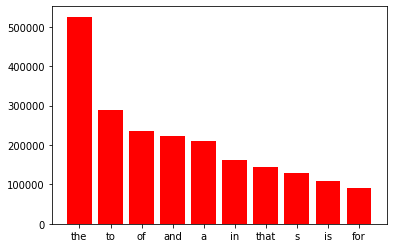

In [41]:
corpus_fake = make_corpus(1)
dic_fake = defaultdict(int)

for word in corpus_fake:
  if word in stop:
    dic_fake[word] = dic_fake[word] + 1

top = sorted(dic_fake.items(), key = lambda x : x[1], reverse = True)[:10]

x,y = zip(*top)
plt.bar(x,y, color = "red");

### Punctuation Analysis


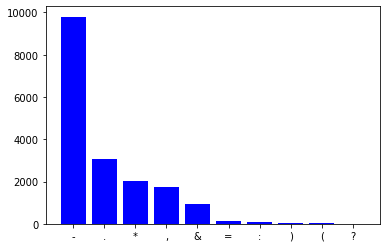

In [42]:
# Corpus Real

dic_real = defaultdict(int)
punct = string.punctuation

for word in corpus_real:
  if word in punct:
    dic_real[word] = dic_real[word] + 1

top = sorted(dic_real.items(), key = lambda x : x[1], reverse = True)[:10]

x,y = zip(*top)
plt.bar(x,y, color = "blue");

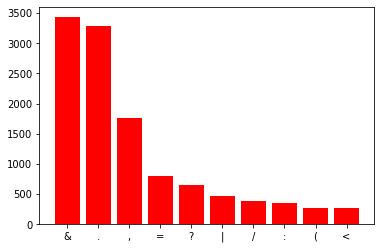

In [43]:
# Corpus Fake

dic_fake = defaultdict(int)
punct = string.punctuation

for word in corpus_fake:
  if word in punct:
    dic_fake[word] = dic_fake[word] + 1

top = sorted(dic_fake.items(), key = lambda x : x[1], reverse = True)[:10]

x,y = zip(*top)
plt.bar(x,y, color = "red");

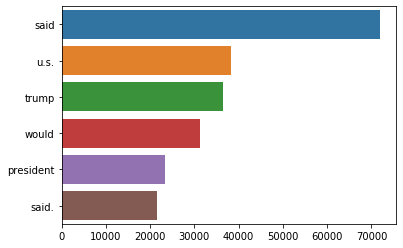

In [44]:
counter = Counter(corpus_real)
most = counter.most_common()

x = []
y = []

for word, count in most[:40]:
  if word not in stop:
    x.append(word)
    y.append(count)

sns.barplot(x = y, y = x);

In [ ]:
counter = Counter(corpus_fake)
most = counter.most_common()

x = []
y = []

for word,count in most[:40]:
  if word not in stop:
    x.append(word)
    y.append(count)

sns.barplot(x = y, y = x);

### Bi-gram Analysis

In [47]:
corpus = corpus_fake + corpus_real

def get_top_bigram(corpus, n=None):

  vec = CountVectorizer(ngram_range = (2,2)).fit(corpus)
  bow = vec.transform(corpus)
  sum_word = bow.sum(axis = 0)
  word_freq = [(word, sum_word[0,idx]) for word, idx in vec.vocabulary_.items()]
  word_freq = sorted(word_freq, key = lambda x : x[1], reverse= True)

  return word_freq[:n]

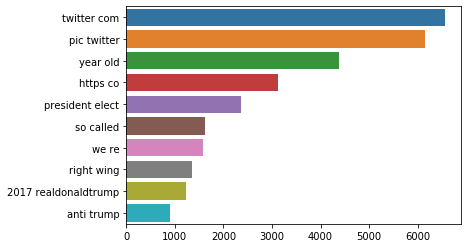

In [46]:
top_bigram = get_top_bigram(corpus, 10)

x,y = map(list, zip(*top_bigram))
sns.barplot(x = y, y = x);

## Preprocessing



### Cleaning

### Splitting Train & Test

## Feature Extraction



### Bag of Words



### GloVe Vectorization

## Modelling



### Random Forest



### Naive Bayes



### Neural Network